# Task C: K-Means Clustering on WeatherAUS Dataset

This notebook performs K-Means clustering on the Australian weather dataset from Kaggle.

## Objectives:
1. Preprocess the weather data by handling categorical variables and missing values
2. Apply K-Means clustering with K values from 2 to 6
3. Visualize clustering results using 2D scatter plots
4. Analyze weather patterns and identify distinct climate groups

### Import Required Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

### Load and Explore the WeatherAUS Dataset

In [13]:
# Load the weather dataset
weather_df = pd.read_csv('data/weatherAUS.csv')

# Display basic information
print("Dataset shape:", weather_df.shape)
print("\nColumn names and types:")
print(weather_df.dtypes)
print("\nFirst 5 rows:")
weather_df.head()

Dataset shape: (145460, 14)

Column names and types:
MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

First 5 rows:


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [14]:
# Check missing values
missing_values = weather_df.isnull().sum()
missing_percent = (missing_values / len(weather_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
}).sort_values('Percentage', ascending=False)

print("Missing values analysis:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing values analysis:
               Missing Count  Percentage
Pressure9am            15065   10.356799
Pressure3pm            15028   10.331363
WindGustSpeed          10263    7.055548
Humidity3pm             4507    3.098446
Temp3pm                 3609    2.481094
RainTomorrow            3267    2.245978
Rainfall                3261    2.241853
RainToday               3261    2.241853
WindSpeed3pm            3062    2.105046
Humidity9am             2654    1.824557
WindSpeed9am            1767    1.214767
Temp9am                 1767    1.214767
MinTemp                 1485    1.020899
MaxTemp                 1261    0.866905


In [15]:
# Display unique values for categorical columns
categorical_cols = weather_df.select_dtypes(include=['object']).columns
print("Categorical columns:")
for col in categorical_cols:
    unique_count = weather_df[col].nunique()
    print(f"\n{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"Values: {weather_df[col].unique()[:10]}")

Categorical columns:

RainToday: 2 unique values
Values: ['No' 'Yes' nan]

RainTomorrow: 2 unique values
Values: ['No' 'Yes' nan]


### Data Preprocessing

In [16]:
# Select features for clustering
# Focus on numerical weather measurements
numerical_features = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
    'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
    'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm'
]

# Check which features exist in the dataset
available_features = [col for col in numerical_features if col in weather_df.columns]
print(f"Available numerical features: {len(available_features)}")
print(available_features)

# Create a subset with selected features
weather_subset = weather_df[available_features].copy()

Available numerical features: 12
['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [17]:
# Handle missing values
print("Missing values before imputation:")
print(weather_subset.isnull().sum())

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
weather_imputed = imputer.fit_transform(weather_subset)
weather_clean = pd.DataFrame(weather_imputed, columns=available_features)

print("\nMissing values after imputation:")
print(weather_clean.isnull().sum().sum())

Missing values before imputation:
MinTemp           1485
MaxTemp           1261
Rainfall          3261
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Temp9am           1767
Temp3pm           3609
dtype: int64

Missing values after imputation:
0


In [18]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(weather_clean)

print("Data shape for clustering:", X_scaled.shape)
print("\nFeature statistics after scaling:")
scaled_df = pd.DataFrame(X_scaled, columns=available_features)
print(scaled_df.describe().loc[['mean', 'std']].round(3))

Data shape for clustering: (145460, 12)

Feature statistics after scaling:
      MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
mean     -0.0      0.0       0.0            0.0           0.0           0.0   
std       1.0      1.0       1.0            1.0           1.0           1.0   

      Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm  
mean          0.0         -0.0         -0.0          0.0      0.0     -0.0  
std           1.0          1.0          1.0          1.0      1.0      1.0  


### Apply PCA for Visualization

In [19]:
# Apply PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create PCA dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

Explained variance ratio: [0.38579073 0.20441379]
Total variance explained: 59.02%


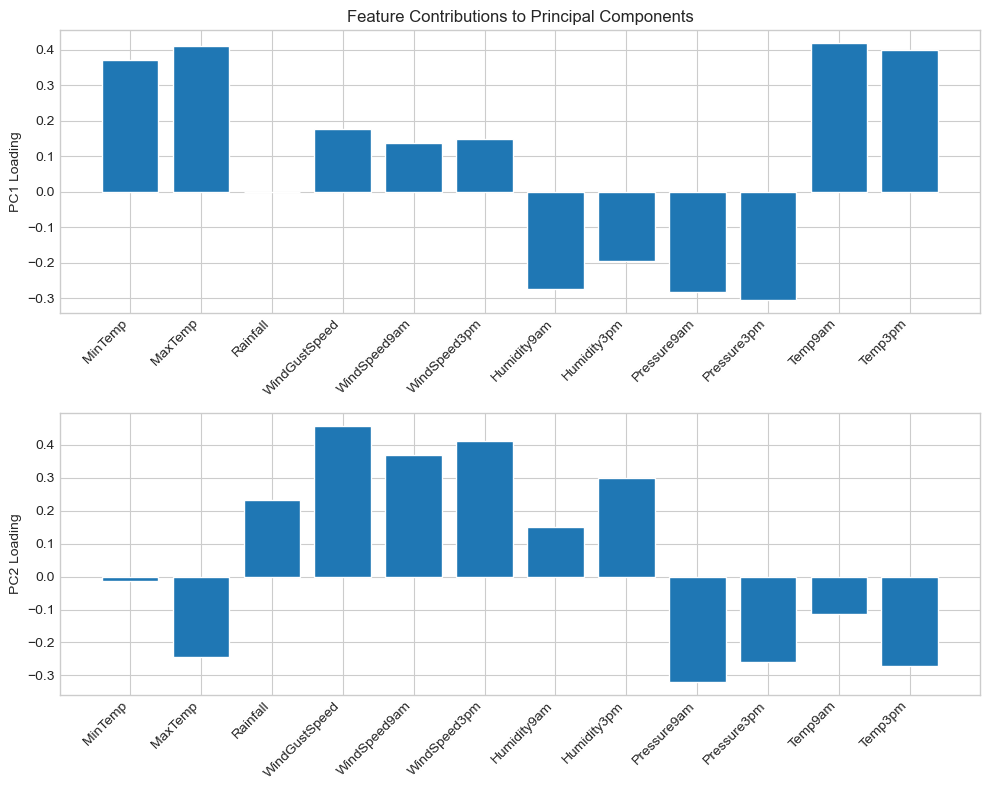

In [20]:
# Visualize feature contributions to principal components
plt.figure(figsize=(10, 8))
components = pca.components_.T
feature_names = available_features

# Create a heatmap
plt.subplot(2, 1, 1)
plt.bar(range(len(feature_names)), components[:, 0])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.ylabel('PC1 Loading')
plt.title('Feature Contributions to Principal Components')

plt.subplot(2, 1, 2)
plt.bar(range(len(feature_names)), components[:, 1])
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
plt.ylabel('PC2 Loading')

plt.tight_layout()
plt.show()

### K-Means Clustering with Different K Values

Note: Using sampling to speed up computation...
Using 20,000 samples out of 145,460 total records
Processing K=2...
Processing K=3...
Processing K=4...
Processing K=5...
Processing K=6...


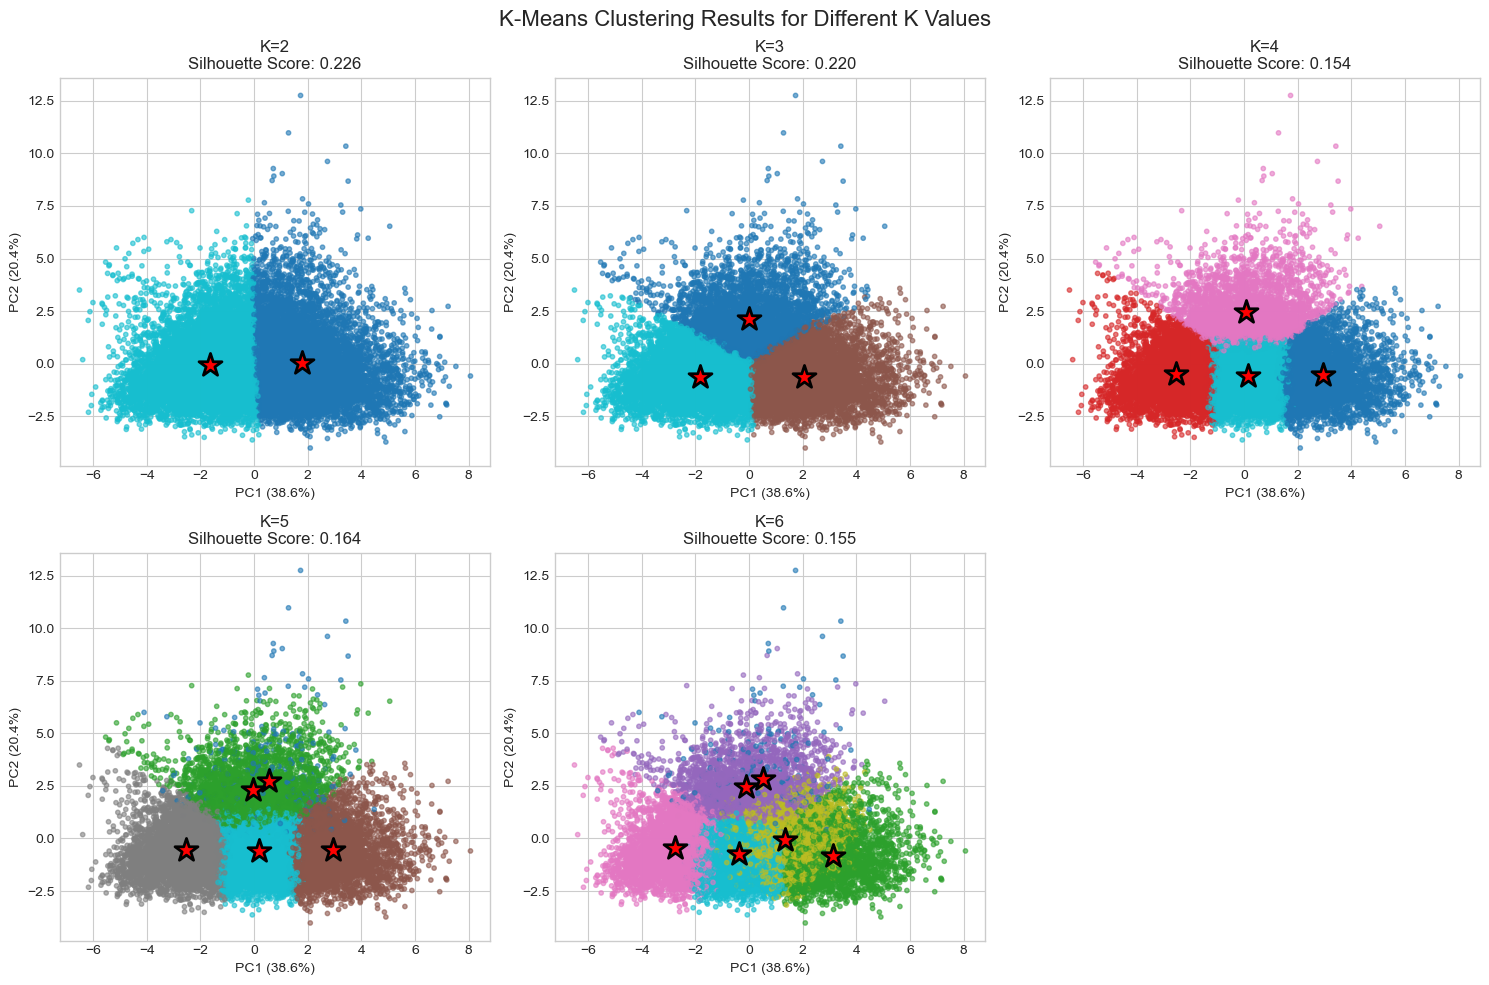


Clustering Metrics for Different K Values:
 K  Silhouette Score          SSE
 2          0.225999 1.310269e+06
 3          0.220030 1.131332e+06
 4          0.153671 1.030778e+06
 5          0.164475 9.531122e+05
 6          0.154880 8.842264e+05

Note: Silhouette scores calculated on 20,000 samples for speed.
SSE calculated on full dataset.


In [22]:
# Test K values from 2 to 6
# Note: Using sampling for faster computation due to large dataset size
print("Note: Using sampling to speed up computation...")
sample_size = 20000  # Adjust this for speed
if len(X_scaled) > sample_size:
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled[sample_indices]
    X_pca_sample = X_pca[sample_indices]
    print(f"Using {sample_size:,} samples out of {len(X_scaled):,} total records")
else:
    X_sample = X_scaled
    X_pca_sample = X_pca
    sample_indices = np.arange(len(X_scaled))

K_values = range(2, 7)
results = []

# Create figure for visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, k in enumerate(K_values):
    print(f"Processing K={k}...")

    # Apply K-Means on sample
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    labels_sample = kmeans.fit_predict(X_sample)

    # Calculate silhouette on sample (much faster)
    silhouette = silhouette_score(X_sample, labels_sample)

    # For full dataset SSE, predict on full data
    if len(X_scaled) > sample_size:
        labels_full = kmeans.predict(X_scaled)
        sse = np.sum((X_scaled - kmeans.cluster_centers_[labels_full])**2)
    else:
        sse = kmeans.inertia_

    results.append({
        'K': k,
        'Silhouette Score': silhouette,
        'SSE': sse,
        'Labels': labels_sample
    })

    # Visualize using PCA (sample only)
    scatter = axes[idx].scatter(X_pca_sample[:, 0], X_pca_sample[:, 1],
                                c=labels_sample, cmap='tab10',
                                s=10, alpha=0.6)

    # Plot cluster centers in PCA space
    centers_pca = pca.transform(kmeans.cluster_centers_)
    axes[idx].scatter(centers_pca[:, 0], centers_pca[:, 1],
                      c='red', marker='*', s=300,
                      edgecolors='black', linewidth=2)

    axes[idx].set_title(f'K={k}\nSilhouette Score: {silhouette:.3f}')
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Remove extra subplot
fig.delaxes(axes[5])
plt.suptitle('K-Means Clustering Results for Different K Values', fontsize=16)
plt.tight_layout()
plt.show()

# Display results table
results_df = pd.DataFrame(results)
print("\nClustering Metrics for Different K Values:")
print(results_df[['K', 'Silhouette Score', 'SSE']].to_string(index=False))

if len(X_scaled) > sample_size:
    print(f"\nNote: Silhouette scores calculated on {sample_size:,} samples for speed.")
    print("SSE calculated on full dataset.")

### Analyze Cluster Characteristics (K=4 as example)

In [24]:
# Use K=4 for detailed analysis (you can change this based on the elbow/silhouette analysis)
optimal_k = 4
kmeans_optimal = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

# Add cluster labels to the original dataframe (subset)
weather_clustered = weather_clean.copy()
weather_clustered['Cluster'] = cluster_labels

# Calculate cluster statistics
cluster_stats = weather_clustered.groupby('Cluster').agg(['mean', 'std'])
print(f"Cluster Statistics for K={optimal_k}:")
print("\nCluster Means:")
print(cluster_stats.xs('mean', level=1, axis=1).round(2))

Cluster Statistics for K=4:

Cluster Means:
         MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
Cluster                                                            
0          11.34    18.74      7.14          55.31         22.73   
1           5.84    16.55      1.45          31.52          9.52   
2          13.04    24.50      1.15          35.91         11.68   
3          19.03    32.70      1.20          43.73         15.92   

         WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
Cluster                                                                     
0               27.37        74.10        63.21      1012.57      1011.36   
1               13.79        80.94        58.31      1023.69      1021.34   
2               16.61        67.06        49.30      1018.65      1016.07   
3               20.54        53.36        37.62      1013.09      1009.97   

         Temp9am  Temp3pm  
Cluster                    
0          14.66    17.02  


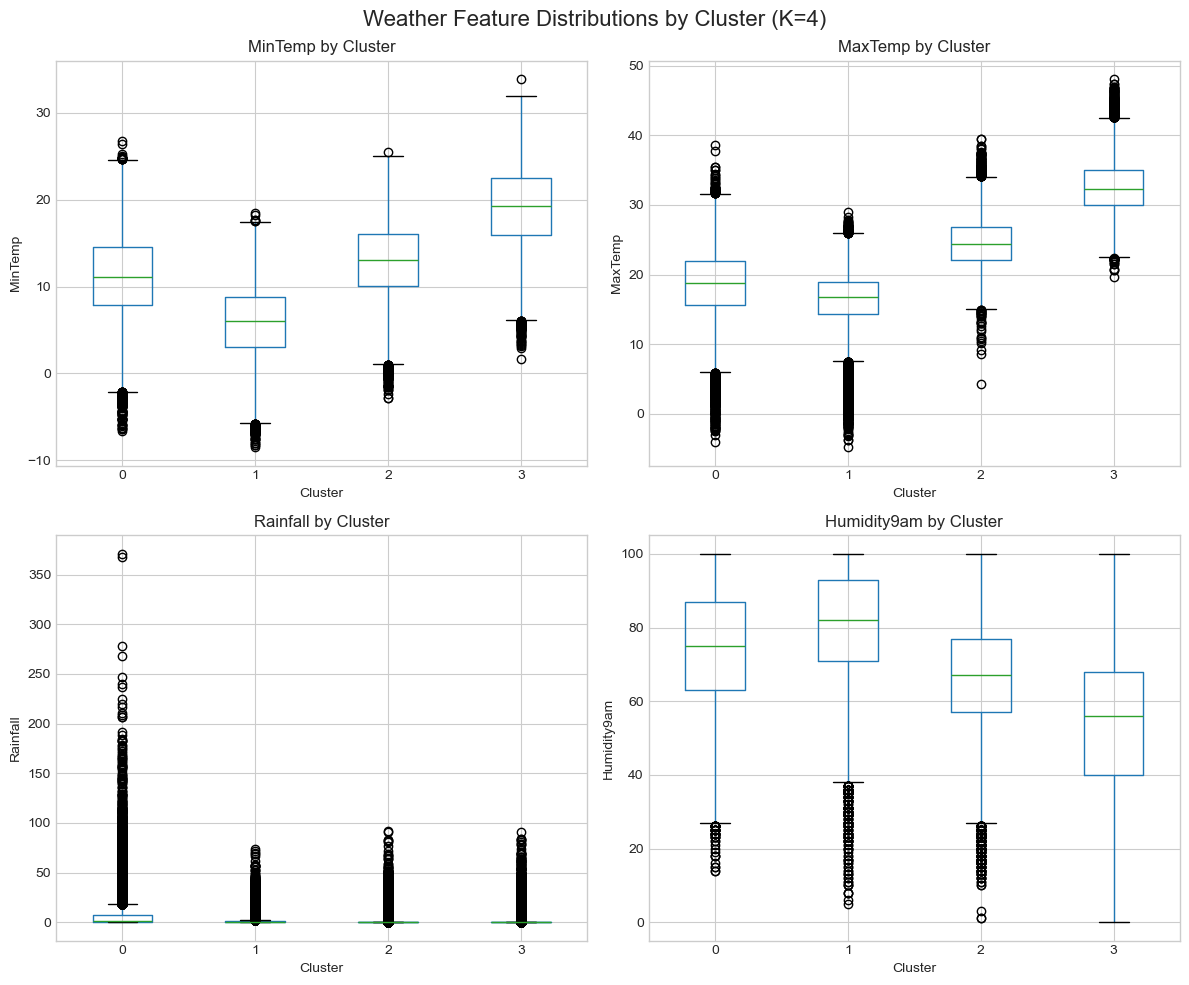

In [25]:
# Visualize cluster characteristics
# Select key features for visualization
key_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am']
available_key_features = [f for f in key_features if f in weather_clustered.columns]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, feature in enumerate(available_key_features[:4]):
    weather_clustered.boxplot(column=feature, by='Cluster', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)

plt.suptitle(f'Weather Feature Distributions by Cluster (K={optimal_k})', fontsize=16)
plt.tight_layout()
plt.show()

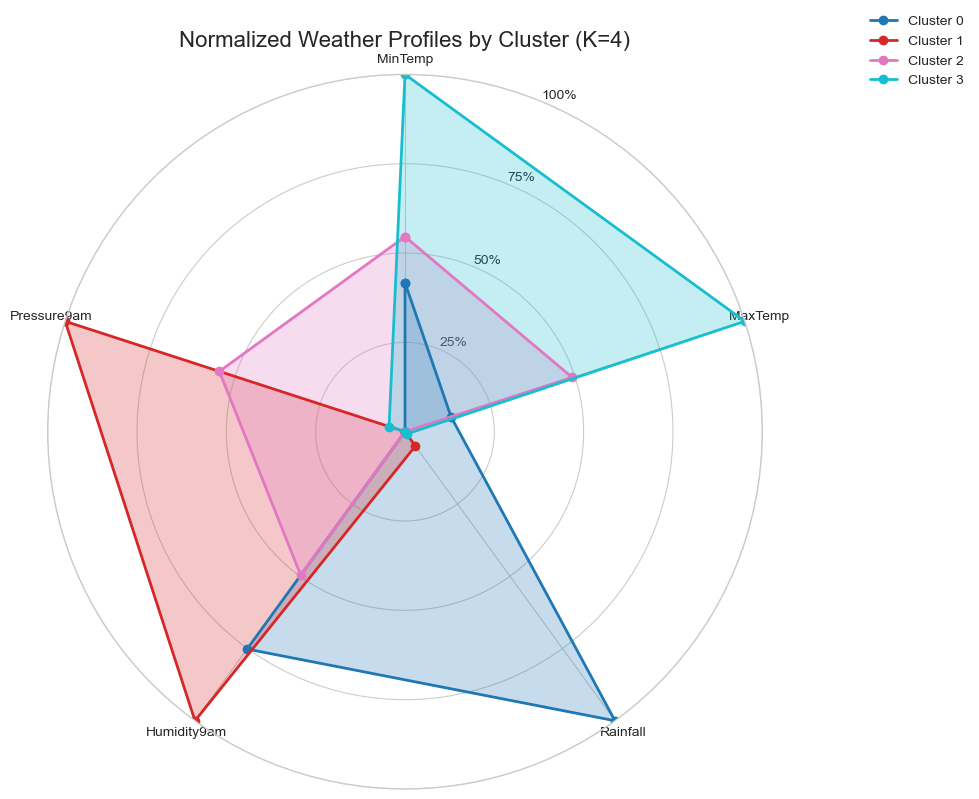

In [26]:
# Create a radar chart for cluster profiles
from math import pi

# Select features for radar chart
radar_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am']
available_radar = [f for f in radar_features if f in weather_clustered.columns]

# Normalize the cluster means for radar chart
cluster_means = weather_clustered.groupby('Cluster')[available_radar].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Number of variables
num_vars = len(available_radar)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each cluster
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    values = cluster_means_norm.loc[i].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {i}', color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(available_radar)

# Set y-axis labels
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1])
ax.set_yticklabels(['25%', '50%', '75%', '100%'])

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title(f'Normalized Weather Profiles by Cluster (K={optimal_k})', size=16, pad=20)
plt.tight_layout()
plt.show()

### Cluster Interpretation

In [28]:
# Interpret clusters based on their characteristics
cluster_interpretation = weather_clustered.groupby('Cluster')[available_features].mean()

print("Cluster Interpretations:")
print("="*50)

for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_data = cluster_interpretation.loc[cluster]
    
    # Temperature characteristics
    if 'MinTemp' in cluster_data and 'MaxTemp' in cluster_data:
        avg_temp = (cluster_data['MinTemp'] + cluster_data['MaxTemp']) / 2
        temp_range = cluster_data['MaxTemp'] - cluster_data['MinTemp']
        print(f"  - Average temperature: {avg_temp:.1f}°C")
        print(f"  - Temperature range: {temp_range:.1f}°C")
    
    # Rainfall
    if 'Rainfall' in cluster_data:
        print(f"  - Average rainfall: {cluster_data['Rainfall']:.1f}mm")
    
    # Humidity
    if 'Humidity9am' in cluster_data:
        print(f"  - Morning humidity: {cluster_data['Humidity9am']:.0f}%")
    
    # Weather type interpretation
    if 'MinTemp' in cluster_data and 'MaxTemp' in cluster_data and 'Rainfall' in cluster_data:
        if avg_temp > 25 and cluster_data['Rainfall'] < 2:
            weather_type = "Hot and Dry"
        elif avg_temp > 20 and cluster_data['Rainfall'] > 5:
            weather_type = "Warm and Wet"
        elif avg_temp < 15 and cluster_data['Rainfall'] < 2:
            weather_type = "Cold and Dry"
        elif avg_temp < 15 and cluster_data['Rainfall'] > 5:
            weather_type = "Cold and Wet"
        else:
            weather_type = "Moderate"
        
        print(f"  - Weather type: {weather_type}")

Cluster Interpretations:

Cluster 0:
  - Average temperature: 15.0°C
  - Temperature range: 7.4°C
  - Average rainfall: 7.1mm
  - Morning humidity: 74%
  - Weather type: Moderate

Cluster 1:
  - Average temperature: 11.2°C
  - Temperature range: 10.7°C
  - Average rainfall: 1.4mm
  - Morning humidity: 81%
  - Weather type: Cold and Dry

Cluster 2:
  - Average temperature: 18.8°C
  - Temperature range: 11.5°C
  - Average rainfall: 1.1mm
  - Morning humidity: 67%
  - Weather type: Moderate

Cluster 3:
  - Average temperature: 25.9°C
  - Temperature range: 13.7°C
  - Average rainfall: 1.2mm
  - Morning humidity: 53%
  - Weather type: Hot and Dry
